In [1]:
%matplotlib inline

In [2]:
cd ~/Desktop/CMBintheLikeHoodz/Likelihood_Comparison

/Users/evanbiederstedt/Desktop/CMBintheLikeHoodz/Likelihood_Comparison


The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072
NSIDE = 16
ORDERING = RING in fits file


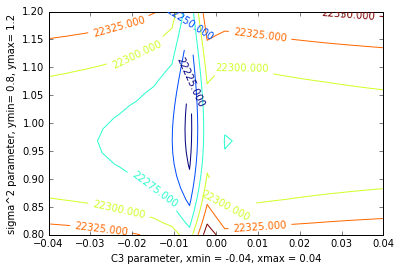

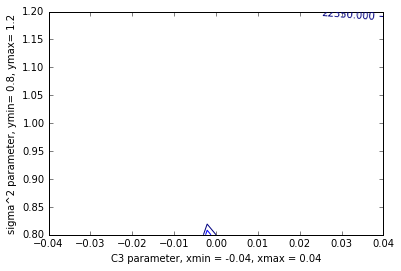

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072
NSIDE = 16
ORDERING = RING in fits file


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/contour.py:380: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


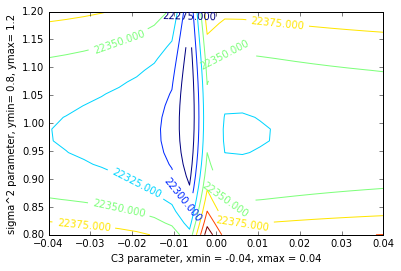

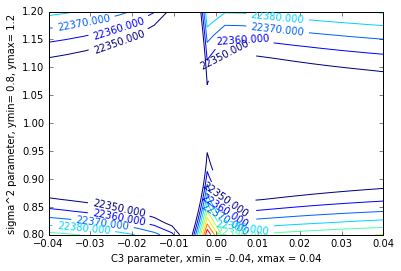

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072
NSIDE = 16
ORDERING = RING in fits file


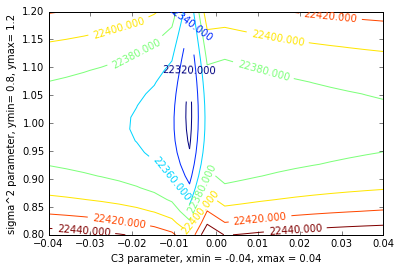

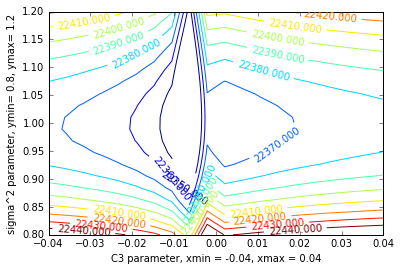

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072
NSIDE = 16
ORDERING = RING in fits file


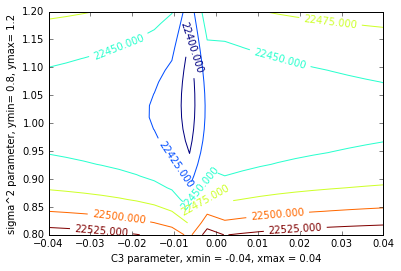

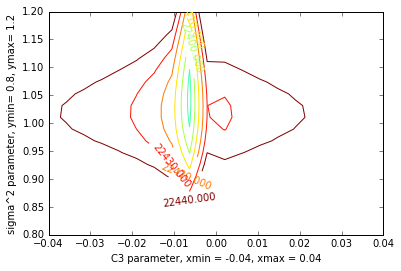

1 loops, best of 3: 11min 39s per loop


In [3]:
%%timeit

import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function


camb1 = "camb_nside16_lmax32_alms.fits"
camb2 = "camb_nside16_lmax32_map.fits"
camb3 = "camb_nside16_lmax32_scalcls.fits"
planck1 = "100GHz_nside16_lmax32_cls.fits"
planck2 = "100GHz_nside16_lmax32_cmb_alm.fits"
planck3 = "100GHz_nside16_lmax32_sky_alm.fits"
planck4 = "100GHz_nside16_lmax32_skymap.fits"

nside = 16


# In[6]:

npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print "The total number of pixels is " + str(npix)
print "The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX)
print "Healpix tells me total number of pixels npix is equal to " + str(heal_npix)


# In[7]:

#
# Begin with a Munich Planck-simulated map, and CAMB Boltzmann-code generated C_l values
#


# In[8]:

# Theoretical scalar C_l array, CAMB
#
# open a FITS file, theoretical C_l values generated by CAMB
# type()=pyfits.hdu.hdulist.HDUList
cl_open = pf.open(camb3)
# recall camb3 = "camb_nside16_lmax32_scalcls.fits"


# In[9]:

theoryCls_arr1 = cl_open[1].data
# print theoryCls_arr1[:10]
# Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
# first two values are zero, i.e. monopole, dipole
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray


# In[10]:

cltemps = theoryCls_arr1.field(0) 
#print cltemps
#print "The length of the array of theoretical Cl's is " +str(len(cltemps))
#print "The array contains [C_0, C_1, C_2,..., C_" +str(len(cltemps)-1) + "]"
#print type(cltemps)=numpy.ndarray


# In[11]:

# remove monopole l=0 and dipole l=1
theoryCl = cltemps[2:]
# len(theoryCl) = 31
# print theoryCl
# theoryCl is np.ndarray of theoretical [C_2, C_3, C_4, ..., C_32]


# In[12]:

# Our input data is Gaerching generated, noiseless full-sky map
# Temperature map: here we use Planck simulated map from Munich, not CAMB map
# http://gavo.mpa-garching.mpg.de/planck/
#
# Read in with Healpy routine/function
#
# Use planck4 = "100GHz_nside16_lmax32_skymap.fits"
# This is a simulated data, 100GHz (where CMB dominates), no foregrounds
# 
mapread_camb2 = hp.read_map(camb2) # Healpix routine, input the sky map


# In[13]:

# hp.mollview(mapread_camb2) # visualization of full-sky CMB map, nside=16, lmax=32


# In[14]:

# The uploaded temperature map is mapread_planck4 = hp.read_map(planck4)
#print type(mapread_camb2) # type(mapread_planck4) = np.ndarray
#print mapread_camb2.shape # mapread_planck4.shape = (3072, ) = (N_pix, )
#
# rename array for convenience
tempval = mapread_camb2
#print tempval


# In[15]:

# Next, we use healpy map2alm to tranform to alm values
# Our input data is CAMB generated, noiseless full-sky map
# We calculate an array of a_lm from this by using Healpix map2alm, a subroutine of anafast
#
# map2alm only outputs m >=0 values, because m = -l values are equivalent to m = +l values
#
# Using map2alm, the length of the alm array is expected to be:
# (mmax * (2 * lmax + 1 - mmax)) / 2 + lmax + 1)"
#
# For mmax = lmax, this is l(l+1)/2 + l + 1
# i.e. 
# l = 0, there is 1
# l = 1, there is 3
# l = 2, there is 6
# l = 3, there is 10
# l = 4, there is 15
# etc.
almarr = hp.map2alm(mapread_camb2)                # This is an array of a_lm values
#print "The array of spherical harmonic coefficients a_lm is"
#print almarr
#print "The arr.shape is " + str(almarr.shape)
#print "The length of a_lm array is " + str(len(almarr))
#
#print "For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)"
#print "However, this is NOT the order of the output! See below"
# In the Fortran F90 subroutines, complex alm are stored in an array that has 
# two dimensions to contain coefficients for positive and negative m values.
# Healpy doesn't do this....I think

#print "============================="
#print "============================="
#print "Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)"
#print "Default ordering of healpy.map2alm() output is "
#print "(0,0), (1,0), ..., (lmax, 0),"
#print "(1,1), (2,1), ...., (lmax, 1),"
#print "(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax)."


# In[16]:

# ==========================
# DEMONSTRATION
# Notice how a_lm is indexed
# ==========================

mmm = np.arange(12) # define a map, i.e. an array of 12 "pixels"
lmaxxx = 4
alm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
lm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
#print(alm)
#print(alm.shape)

# So alm is actually a 1D vector.
# How is alm indexed?


l, m = hp.Alm.getlm(lmax=lmaxxx)
#print(l)

#print(m)




#print "The l values are "+str(l)
#print "The m values are "+str(m)
#print " (l,m) is in order " +str(list(zip(l,m)))
#
# l, m = hp.Alm.getlm(lmax=lmax)
# print(l)
# [0 1 2 1 2 2]
# print(m)
# [0 0 0 1 1 2]
#
#
# So, for l = 2, m is [0, 1, 2].
#
# ==========================
# Notice how a_lm is indexed
# ==========================
#
#
#


# In[17]:

# Check with healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
ell, emm = hp.Alm.getlm(lmax=32)

#print "len(ell) is " +str(len(ell))
#print "len(emm) is "+str(len(emm))
#print "l values are "+str(ell[:10])
#print "m values are "+str(emm[:10])
pairs = list(zip(ell, emm)) # put values together in pairs, zip()
ellemm = np.vstack((ell,emm)).T  # equivalent to list(zip(ell,emm)), but uses numpy throughout
#print "Indices for a_lm for lmax (l, m) are:" 
#print str(pairs[:50]) # The expected output


# In[18]:

#print ellemm[:10]


# In[19]:

#
# For our first test, mode l = 3, we need to access a_lm coefficients a_30, a_31, a_32, a_33
# To find this for lmax = 32, we use
# healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
# Find the indices
index_a30 = hp.Alm.getidx(lmax=32, l=3, m=0)
index_a31 = hp.Alm.getidx(lmax=32, l=3, m=1)
index_a32 = hp.Alm.getidx(lmax=32, l=3, m=2)
index_a33 = hp.Alm.getidx(lmax=32, l=3, m=3)


# In[20]:

#print "Index a_30 is " +str(index_a30)
#print "Index a_31 is "+str(index_a31)
#print "Index a_32 is "+str(index_a32)
#print "Index a_33 is "+str(index_a33)


# In[21]:

#
# Create an array with only the values a_3m, i.e. a_30, a_31, a_32, a_33
#
# First convert the array of alm coefficients into a real
#
realalm = almarr.real
#
#print realalm[:36]


# In[22]:

empty_almlist = []
#
a30 = realalm[3]
a31 = realalm[35]
a32 = realalm[66]
a33 = realalm[96]
#
#print "a30 is " + str(a30)
#print "a31 is " + str(a31)
#print "a32 is " + str(a32)
#print "a33 is " + str(a33)
#
#print str(pairs[3]) # Check with our output above
#print str(pairs[35])
#print str(pairs[66])
#print str(pairs[96])
#
empty_almlist.append(a30)
empty_almlist.append(a31)
empty_almlist.append(a32)
empty_almlist.append(a33)
#
#print empty_almlist


# In[23]:

# create array of real-valued alm coefficients, a30 a31 a32 a33
realalm3 = np.asarray(empty_almlist) # np.asarray() converts input into an array
#print realalm3


# In[24]:

# Repeat the above procedure for mode l = 4, i.e. a40 a41 a42 a43 a44
# Find the indices
index_a40 = hp.Alm.getidx(lmax=32, l=4, m=0)
index_a41 = hp.Alm.getidx(lmax=32, l=4, m=1)
index_a42 = hp.Alm.getidx(lmax=32, l=4, m=2)
index_a43 = hp.Alm.getidx(lmax=32, l=4, m=3)
index_a44 = hp.Alm.getidx(lmax=32, l=4, m=4)
#
#print "Index a_40 is " +str(index_a40)
#print "Index a_41 is "+str(index_a41)
#print "Index a_42 is "+str(index_a42)
#print "Index a_43 is "+str(index_a43)
#print "Index a_44 is "+str(index_a44)
#
# Check with the above ouput
#print str(pairs[4]) 
#print str(pairs[36])
#print str(pairs[67])
#print str(pairs[97])
#print str(pairs[126])
#
emptylistalm2 = []
#
#print realalm
#
a40 = realalm[4]
a41 = realalm[36]
a42 = realalm[67]
a43 = realalm[97]
a44 = realalm[127]
#
#print "a40 is " + str(a40)
#print "a41 is " + str(a41)
#print "a42 is " + str(a42)
#print "a43 is " + str(a43)
#print "a44 is " + str(a44)
#
emptylistalm2.append(a40)
emptylistalm2.append(a41)
emptylistalm2.append(a42)
emptylistalm2.append(a43)
emptylistalm2.append(a44)
#
#print emptylistalm2


# In[25]:

# create array of real-valued alm coefficients, a40 a41 a42 a43 a44
realalm4 = np.asarray(emptylistalm2) # np.asarray() converts input into an array
#print realalm4


# In[26]:

# Calculate (abs(alm))**2 i.e. |alm|^2
abs_alm3 = np.absolute(realalm3)
abs_alm4 = np.absolute(realalm4)
#print abs_alm3
#print abs_alm4
# Now calculate the squares element-wise, x**2
alm3_squared = abs_alm3**2
alm4_squared = abs_alm4**2
#print alm3_squared
#print alm4_squared


# In[27]:

# For l = 3 test, we need theoretical value of C_3; ditto for l = 4
#print theoryCl
C3 = theoryCl[1]
#print "theory C_3 is " +str(C3)
C4 = theoryCl[2]
#print "theory C_4 is "+str(C4)


# In[28]:

# For lmax = 32, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(33)
#print ell
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
#print ellval 


# In[29]:

# Calculate an array of (2*l + 1)C_l 
# i.e. 5*C_2, 7*C_3, 9*C_4, 11*C_5, 13*C_6, ...
#print theoryCl

for i in ellval:
    paramsCl = (2*ellval + 1)*theoryCl # define array (2*l + 1)C_l 
    
#print paramsCl


# In[30]:

norm = ((2*ellval + 1))/(4*math.pi)
#print norm


# In[31]:

anafastCl = hp.anafast(mapread_camb2, lmax=32)
#len(anafastCl) = 33
# remove monopole and dipole values, l=0, l=1
hatCl = anafastCl[2:] #len() = 31, type() = np.ndarray
hatC3 = hatCl[1]   # index 0 = C2, 1 = C3, etc.
hatC4 = hatCl[2]
#print hatC3
#print hatC4


# In[32]:

# 
# Add a_lm squared, |a_lm|^2
#
#print "The values for |a_lm|^2 are : "
#print "For |a_3m|**2 such that a_30, a_31, a_32, a_33: "
#print str(alm3_squared)
#print "And for |a_4m|**2 such that a_40, a_41, a_42, a_43, a_44: "
#print str(alm4_squared)



# In[33]:

# =========================================================================
#
# =========================================================================
#
# Data:
#     tempval      # the array of pixel values, (3072,)
#     realalm3     # array of alm values, a30, a31, a32, a33 
#     realalm4     # array of alm values, a40, a41, a42, a43, a44
#     alm3_squared # array of |alm|^2, (abs(a3m))**2
#     alm4_squared # array of |alm|^2, (abs(a4m))**2
#     hatCl        # array of anafast-calculated \hat{C}_l values, l=2 to l=32
#     hatC3        # \hat{C}_3 value
#     hatC4        # \hat{C}_4 value
#
# Parameters:
#     theoryCl     # array of Boltzmann code generated C_l, i.e. C^{theory}_l
#     paramsCl     # array of (2*l + 1)C_l from l=2 to l=lmax
#     C3           # array of C_3 value
#     C4           # array of C_4 value
#    
# Array of ell's: 
#     ellval       # array of l = 2 to l=lmax
#                  # [2 3 4 ... 31 32]
#     norm         # array of (2*l+1)/4pi
#                  # [5/4pi 7/4pi 9/4pi 11/4pi ... 63/4pi 65/4pi]
# =========================================================================
#
# =========================================================================


# In[34]:

#
# Next, create the matrix, n_i /cdot n_j
# solely using Healpy routines, i.e. taking the dot product of the vectors
# The result is "dotproductmatrix"
#
# npix = 3072


# In[35]:

totalpix = np.arange(npix) # An array indexing the total number of pixels


# In[36]:

## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple
#
#
vecval = hp.pix2vec(nside, totalpix) #Nside = 16, type()=tuple


# In[37]:

vecvalx = vecval[0] #shape (3072,)
vecvaly = vecval[1]
vecvalz = vecval[2]


# In[38]:

# First arrange arrays vertically
# numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays
totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray


# In[39]:

trans = totalvecval.T #transpose


# In[40]:

dotproductmatrix = trans.dot(totalvecval) #take the dot product
# dotproductmatrix.shape = (npix, npix) = (3072, 3072)
# type(dotproductmatrix) = np.ndarray


# In[41]:

# =========================================================
# =========================================================
#
# \Sum_l (2*l + 1)/4pi C^th_l P_l (dotproductmatrix)
# sum from l=2 to l=lmax
#
# arrays l = [2 3 4 .... lmax]
#        C_l = [C_2 C_3 .... C_lmax]
#
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         
#
#
# =========================================================
# =========================================================


# In[42]:

# =========================================================
# =========================================================
#
# Now calculate the likelihood 
# -2lnL \propto m^T C^-1 m + ln det C + N ln (2pi)
#
# First term, m^T C^-1 m is the "model fit term"
# Second term, lndetC is the "complexity penalty"
# Third term, N ln 2pi, a constant
#
# m = tempval
# C = Sij
#
# STEP 1: do inverse of Sij
#        invSij = np.linalg.inv(Sij)
#
# STEP 2: do matrix mulplication, m.T*inv(C)*m
#       
# lnL_modelfit_terms = np.array([np.dot(tempval.T , np.dot(invSij[i] , tempval) ) for i in range(invSij.shape[0])])
#
# STEP 3: do logdet Sij
#
# logdetC = np.linalg.slogdet(Sij) #computes sign and log det C
# logdetC[1]
#
# STEP 4: compute N_pix * 2pi
#
# Npix2pi = (npix)*2*math.pi
#
# Step 5: -2loglikelihood = m.T*inv(C)*m + logdetC[1] + Npix2pi
# 
# =========================================================
# =========================================================


# In[43]:

# CODE BOTTLENECK!
# 
# Evaluate Legendre from l=2 to l=lmax for each matrix entry
# [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# 
# WITHOUT BROADCASTING, one would do something like 
# PlMat = []
# for i in ellval:
#    PlMat.append( eval_legendre(i, dotproductmatrix) )
#
#
# With broadcasting, we use
PlMat = eval_legendre(ellval[:, None, None], dotproductmatrix)
# PlMat = [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# PlMat is an array, len()=31 of 31 3072 by 3072 matrices
# PlMat.shape = (31, 3072, 3072)


# In[44]:

# multiply PlMat by (2*l+1)/4pi, i.e. norm
norm_matrix = norm[:, None, None] * PlMat
# [5/4pi * P_2(M)  7/4pi * P_3(M) ....   65/4pi * P_32(M)]

#print PlMat.shape
#print norm_matrix.shape


# In[45]:

### Try l=2 to =3
### Try l=3
### could try l=0 plus 1, 2, 3


# In[ ]:




# In[ ]:




# In[46]:

# JULY 1, 2015
#
#
# Here we define the LF 
#
# Next we should writen the REAL-space log-likelihood, -2 lnLikefunction
# this is a function of parameters
# plot against parameters, theory C_l
#
# Likelihood function should use -2lnL /propto m^T C^-1 M + log det M
#


# In[47]:

# TEST C_3 Likelihood
#
# The covariance matrix is a function of variable "x" where "x" is "C_3", an unknown parameter. 
# 
# Our covariance matrix is therefore S_ij  = 7/4pi * x * P_3(matrix)   
# (We set l=3, i.e. l=3, and P_3)
# 
# The LF is then a function of x, LF(x). This is the only parameter we vary. 
#
# LF = -2loglikelihood /propto T^T inv(S_ij) T + log det (Sij) + N log (2pi)
# 
# We then plot LF(x) vs. parameters x. 
#


# In[48]:

# define pixel-value arrays
mT = np.matrix(tempval)     # mT.shape = (1, 3072)
m = np.matrix(tempval).T    # m.shape = (3072, 1)
Npix2pi = (npix)*2*math.pi  # LF constant



# In[49]:

#print C3 # Boltzmann code CAMB output


# In[50]:

# generate a number of samples to plot for x
# Boltzmann code value for C3 is 5.88275e-10
# start at 1e-10, end at 9e-10
# default samples generated is 50


# In[51]:

vary_x_samples1 = np.linspace(1e-10, 9e-10, num=20 ) #set default num = 20


# In[52]:

#print vary_x_samples1


# In[53]:

# create Sij array, len()=31, l=2 to l=32
# Sij = norm_matrix * theoryCl[:, None, None]
# [5/4pi*C_2*P_2(M)  7/4pi*C_3*P_3(M) ....   65/4pi*C_32*P_32(M)]


# In[54]:

#print hatC3  # anafast generated C_l for l = 3 from sky map
#print C3     # CAMB generated C_3, Boltzmann code output


# In[55]:

#print alm3_squared  # a_3m extracted from sky map, absolute value, squared


# In[56]:

np.set_printoptions(threshold=100000)  # Default is threshold=1000
## Use this to print all values, disables corner printing


# In[57]:

#
# The empirical variance from our map is Var(a3m)
#
# print alm3_squared
# [  8.84771791e-13   8.06516529e-18   3.85347491e-12   7.58705140e-11]
#
# Initialize the noise parameter sigma^2 to these values
# The range is wide; try 5e-11 to 5 e-15
#
sigma2 = np.logspace(-12, -16, num=30 ) #set default num = 30
#print sigma2


# In[58]:

# For N matrix, set the identity
id_mat = np.identity(3072)
#print id_mat    # This is a (3072, 3072) matrix
noiseresult = sigma2[:, None, None] * id_mat[None, :, :]
#print noiseresult


# In[59]:

correctmatrix = norm_matrix[0] + norm_matrix[1]
#print correctmatrix


# In[60]:

tempp = np.random.normal(0.0, 1.0, 3072) # mean = 0, std = 1 = var = 1

def LogLikehood_wNoise_contour(param, sig):
    # param is our parameter, C_3
    Sij = param * correctmatrix[None, :, :]
    Nij = sig * id_mat[None, :, :]
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = Sij + Nij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi


# In[62]:

import pylab as pb    
import matplotlib.pyplot as plt 

vary_C3 = np.linspace(-0.04, 0.04, num=20) 
varysigma = np.linspace(0.8, 1.2, num=20)

xxx = vary_C3
yyy = varysigma

zzz = np.array([[LogLikehood_wNoise_contour(np.asarray(i), np.asarray(j)) for i in xxx] for j in yyy])

zzzreshaped = zzz.reshape(20,20)

plt.figure()
CS = plt.contour(xxx, yyy, zzzreshaped)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('C3 parameter, xmin = -0.04, xmax = 0.04')
plt.ylabel('sigma^2 parameter, ymin= 0.8, ymax= 1.2')
pb.show()

plt.figure()
levels = np.arange(22350.0, 22450.0, 10)
CS = plt.contour(xxx, yyy, zzzreshaped, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('C3 parameter, xmin = -0.04, xmax = 0.04')
plt.ylabel('sigma^2 parameter, ymin= 0.8, ymax= 1.2')
pb.show()

